In [2]:
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

In [3]:
def read_trc(fpath):
    # read metadata in file header
    df_meta = pd.read_csv(fpath, delimiter='\t', header=0, skiprows=1, nrows=1)
    meta = df_meta.iloc[0].to_dict()
    fps = meta['DataRate']

    # read marker location names
    markers_df = pd.read_csv(fpath, delimiter='\t', header=None, skiprows=3, nrows=1)
    markers = markers_df.iloc[0].dropna().to_numpy()[2:]

    # read marker XYZ locations
    df = pd.read_csv(fpath, delimiter='\t', header=0, skiprows=4)
    df.rename(columns=dict(zip(df.columns[:2], ('n', 't'))), inplace=True)
    df.dropna(how='all', axis=1, inplace=True)

    N = df.shape[0]
    M = len(markers)
    xyz = df.iloc[:,2:].to_numpy().reshape((N, M, 3))
    xyz[:,:,[0,1,2]] = xyz[:,:,[2,1,0]]

    return fps, markers, xyz


def read_mot(fpath):
    with open(fpath, 'r') as f:
        # count = 0
        line = f.readline().strip()
        # while line and line.strip() != 'endheader':
        while line.lower() != 'endheader':
            line = f.readline().strip()
            # count += 1

        # df = pd.read_csv(f, delimiter='\t', header=0, skiprows=count-3)
        df = pd.read_csv(f, delimiter='\t', header=0)

    return df

In [4]:
# Define function to normalize joint angles across all data
def normalize_data(data_list):
    """
    Normalizes a list of numpy arrays using MinMax scaling across all features.
    Arguments:
        data_list: List of numpy arrays where each array corresponds to one time series.
    Returns:
        normalized_data: List of normalized numpy arrays.
    """
    # Flatten all data for joint normalization across the dataset
    all_data = np.concatenate(data_list, axis=0)
    
    # Apply MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(all_data)  # Fit scaler on all joint angles across the dataset
    
    # Normalize each time series
    normalized_data = [scaler.transform(data) for data in data_list]
    return normalized_data, scaler

# Define function to pad time series to the same length
def pad_time_series(data_list, max_length=None):
    """
    Pads all time series in data_list to the same length.
    Arguments:
        data_list: List of numpy arrays where each array corresponds to one time series.
        max_length: If None, pad to the longest time series. Otherwise, pad to max_length.
    Returns:
        padded_data: Numpy array of shape (num_samples, max_length, num_features).
    """
    if max_length is None:
        max_length = max(len(data) for data in data_list)  # Find the longest time series
    padded_data = pad_sequences(data_list, maxlen=max_length, padding="post", dtype="float32")
    return padded_data

In [5]:
def get_label_for_participant_trial(class_df, pid, trial):
    """
    Fetches the label for a given participant and trial based on class_info.csv.
    
    Parameters:
        participant_id (str): The ID of the participant.
        trial (str): The trial name or ID.
    
    Returns:
        int: Classification label (0 or 1).
    """
    label = class_df.loc[class_df['ID'] == pid, 'Class'].values[0]
    return label

In [6]:
# Directory containing .mot files
root_dir = '/Users/kristensteudel/Documents/datadir/opencap_data'  # path to root data dir 
#labels_csv = '/Users/kristensteudel/datadir/class_info.csv'
labels_csv = 'class_info.csv'
class_df = pd.read_csv(labels_csv)

labels = []  # List to store labels (0 or 1)
time_series_data = []  # List to store time series data

expected_columns = [
        'pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx',
        'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r',
        'hip_rotation_r', 'knee_angle_r', 'ankle_angle_r',
        'subtalar_angle_r', 'mtp_angle_r', 'hip_flexion_l', 'hip_adduction_l',
        'hip_rotation_l', 'knee_angle_l', 'ankle_angle_l',
        'subtalar_angle_l', 'mtp_angle_l', 'lumbar_extension', 'lumbar_bending',
        'lumbar_rotation', 'arm_flex_r', 'arm_add_r', 'arm_rot_r',
        'elbow_flex_r', 'pro_sup_r', 'arm_flex_l', 'arm_add_l', 'arm_rot_l',
        'elbow_flex_l', 'pro_sup_l'
    ]

# Loop through all .mot files
for i in range(129):
        # ensure going in order!
        num = str(i+1).zfill(3)

        for path in Path(root_dir).rglob(f"P{num}*/**/walk.mot"): # START WITH JUST WALK TRIALS
            trial = str(path).split('/')[-3]
            pid = str(path).split('/')[-4]
            activity = str(path).split('/')[-2]
            print(str(path))
            # Load the .mot file
            
            data = read_mot(str(path))
            
            
            # Ensure the file has the expected columns
            if not all(col in data.columns for col in expected_columns + ['time']):
                raise ValueError(f"File {path} does not contain the expected columns.")
            
            # Drop the 'time' column and keep only relevant features
            data = data[expected_columns]
            
            time_series_data.append(data)

        
            # Assign labels based on file naming convention or external source
            # Replace this logic with your actual labeling logic
            label = get_label_for_participant_trial(class_df, pid, trial)
            labels.append(label)
# Normalize the time series data
normalized_data, scaler = normalize_data(time_series_data)

# Pad the time series to the same length
padded_data = pad_time_series(normalized_data)

# Convert labels to a numpy array
labels = np.array(labels)

print("Shape of padded data:", padded_data.shape)
print("Shape of labels:", labels.shape)

/Users/kristensteudel/Documents/datadir/opencap_data/P001/0/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P002/0/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P003/0/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P004/0/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P005/0/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P006/0/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P007/407/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P007/0/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P008/0/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P009/453/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P009/0/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P010/407/walk/walk.mot
/Users/kristensteudel/Documents/datadir/opencap_data/P010/0/walk/walk.mot
/Users/kristensteudel/Documents/

/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/kristensteudel/miniconda3/en

In [7]:
padded_data.shape
labels.shape
labels

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0])

In [8]:
# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),  # Masking for padded values
        LSTM(64, return_sequences=True),  # First LSTM layer
        Dropout(0.3),  # Dropout for regularization
        LSTM(32),  # Second LSTM layer
        Dropout(0.3),
        Dense(16, activation='relu'),  # Fully connected layer
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [9]:
# data loader
def data_generator(X, y, batch_size):
    num_samples = len(X)
    while True:
        for offset in range(0, num_samples, batch_size):
            X_batch = X[offset:offset+batch_size]
            y_batch = y[offset:offset+batch_size]
            yield np.array(X_batch), np.array(y_batch)


In [10]:


# Ensure consistent shuffling for reproducibility
np.random.seed(42)

def manual_train_test_split(data, labels, train_ratio=0.8):
    """
    Manually splits data and labels into training and testing sets with the given ratio.
    Arguments:
        data: Preprocessed time series data (numpy array).
        labels: Corresponding labels (numpy array).
        train_ratio: Proportion of data to use for training (default 0.8).
    Returns:
        X_train, X_test, y_train, y_test: Split data and labels.
    """
    # Shuffle the indices
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    
    # Calculate the split point
    split_point = int(len(data) * train_ratio)
    
    # Split the data and labels
    train_indices = indices[:split_point]
    test_indices = indices[split_point:]
    
    X_train = data[train_indices]
    X_test = data[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
    
    return X_train, X_test, y_train, y_test


In [11]:
# Perform the manual train-test split
X_train, X_test, y_train, y_test = manual_train_test_split(np.array(padded_data), np.array(labels))

# Check the shapes of the resulting datasets
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)


# Convert to numpy arrays
X_train = np.array(X_train)
#X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
#y_val = np.array(y_val)
y_test = np.array(y_test)

# Define input shape (timepoints, features)
input_shape = (X_train.shape[1], X_train.shape[2])

# Build model
model = build_lstm_model(input_shape)

# Train the model
history = model.fit(
    X_train, y_train,
    #validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)




Training data shape: (129, 2295, 33)
Training labels shape: (129,)
Testing data shape: (33, 2295, 33)
Testing labels shape: (33,)
Epoch 1/50


/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 559ms/step - accuracy: 0.6750 - loss: 0.6545
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 579ms/step - accuracy: 0.6811 - loss: 0.6323
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 597ms/step - accuracy: 0.6789 - loss: 0.6342
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 620ms/step - accuracy: 0.6738 - loss: 0.6087
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 601ms/step - accuracy: 0.6480 - loss: 0.6657
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 638ms/step - accuracy: 0.6661 - loss: 0.6104
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 600ms/step - accuracy: 0.6710 - loss: 0.6657
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 592ms/step - accuracy: 0.6741 - loss: 0.6669
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 626ms/step - accuracy: 0.6791 - loss: 0.6391
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 599ms/step - accuracy: 0.6881 - loss: 0.6056
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 600ms/step - accuracy: 0.6435 - loss: 0.6379
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 615ms/step - accuracy: 0.7113 - loss: 0.5948


In [12]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.5323, Test Accuracy: 0.6970


KeyError: 'val_loss'

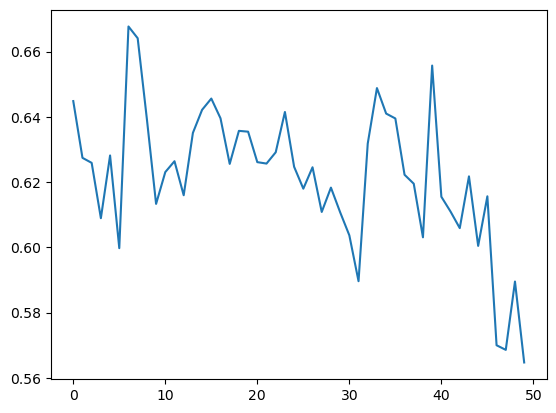

In [13]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()
